# Extracting Business Cycles from Time Series

To characterize cycles, we decompose a time series $y_t$ into a non-stationary component $\tau_t$ (a trend) and a stationary component $c_t$ (cycles):

$$
y_t = \tau_t+c_t
$$

In economics we think of the trend as relating to long-run behavior of the economy, and the cycle as the short-run behavior.  GDP, for example, grows over time at some trend, but is periodically hit by shocks that result in either booms or busts.  There are many different statistical methods for extracting the cyclical component from the raw data.

Many economic time series data exhibit exponential growth, so often the first thing we do is transform them by taking the logarithm.  If $Y_t$ is a time series that grows at some constant rate $g$ and is subject to random deviations proportional to the current level, then we describe it by

$$
Y_t = (1+g)Y_{t-1}+Y_{t-1}\epsilon_t
$$

then the percentage change is given by
$$
\frac{Y_t-Y_{t-1}}{Y_{t-1}}=g+\epsilon_t
$$

Therefore $y_t=\ln(Y_t)$ will have a linear time trend with slope $g$.  We should take the logarithm of variables that we expect to grow exponentially (e.g. GDP, population, consumption) but not variables we expect to be relatively constant over time (e.g. unemployment rate, savings rate).

Once we have transformed data that looks like it exhibits a linear time trend, then we can pick a method to filter out the trend from the cycle.   The python packages `scipy.signal` (<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html" target="_blank">Scipy</a>)and `statsmodels` (<a href="https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_filters.html" target="_blank">StatsModels</a>) are a very convenient way to filter macro time series, and I'll use this package in several of the examples below.  Don't forget to install the package if you haven't already done so:
```
python -m pip install statsmodels
python -m pip install scipy
```

## Log-linear and log-quadratic filter

The most simple way of detrending is to run a regression on $y_t$ with a linear time-trend:

$$
y_t = \alpha+g_t+\epsilon_t
$$

where $\tau_t = \alpha+g_t$ is the trend component and $c_t=\epsilon_t$ is the cyclical component.  Alternatively, if a linear time trend isn't enough to accurately filter the data (although it usually is with logged data), then one could also consider a quadratic term:

$$
y_t = \alpha+g_1 t+g_2 t^2+\epsilon_t
$$

Either specification can be estimated using OLS, however there are many packages that easily implement a linear and quadratic filter on time series data directly.


Detrending complete.


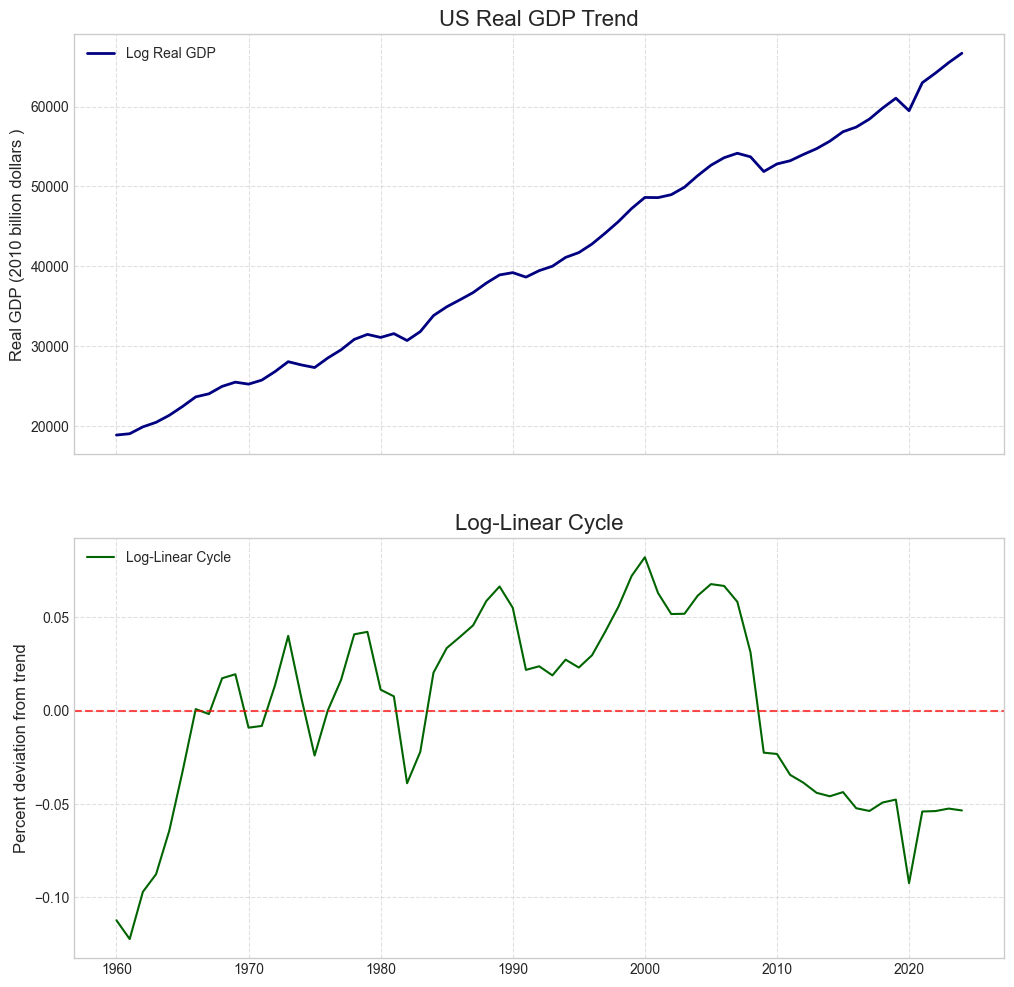

In [37]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Import the data
real_gdp = pd.read_excel('rgdp_usa.xlsx',index_col=0)
real_gdp.index = pd.to_datetime(real_gdp.index)

#Keep date from:
keep_date = pd.to_datetime('1947-01-01')
real_gdp = real_gdp[real_gdp.index > pd.to_datetime(keep_date)]
real_gdp.head()

#Log data
log_real_gdp = np.log(real_gdp['GDPC1']).values

# Log-linear filter
detrended_linear = detrend(log_real_gdp, type='linear') 
detrended_linear = pd.Series(detrended_linear, index=real_gdp.index, name='Cycle (Log-Linear)')

print("\nDetrending complete.")

# Plot the filtered GDP series
plt.style.use('seaborn-v0_8-whitegrid')
    
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Top Plot: Original Log GDP (Trend + Cycle)
axes[0].plot(real_gdp.index, real_gdp, label='Log Real GDP', color='navy', linewidth=2)
axes[0].set_title('US Real GDP Trend', fontsize=16)
axes[0].set_ylabel('Real GDP (2010 billion dollars )', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Bottom Plot: Log-Linear Cycle (Residuals)
axes[1].plot(detrended_linear.index, detrended_linear, label='Log-Linear Cycle', color='darkgreen', linewidth=1.5)
axes[1].axhline(0, color='red', linestyle='--', alpha=0.7)
axes[1].set_ylabel('Percent deviation from trend', fontsize=12)
axes[1].set_title('Log-Linear Cycle', fontsize=16)
axes[1].legend(loc='upper left')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.show()


Detrending complete.


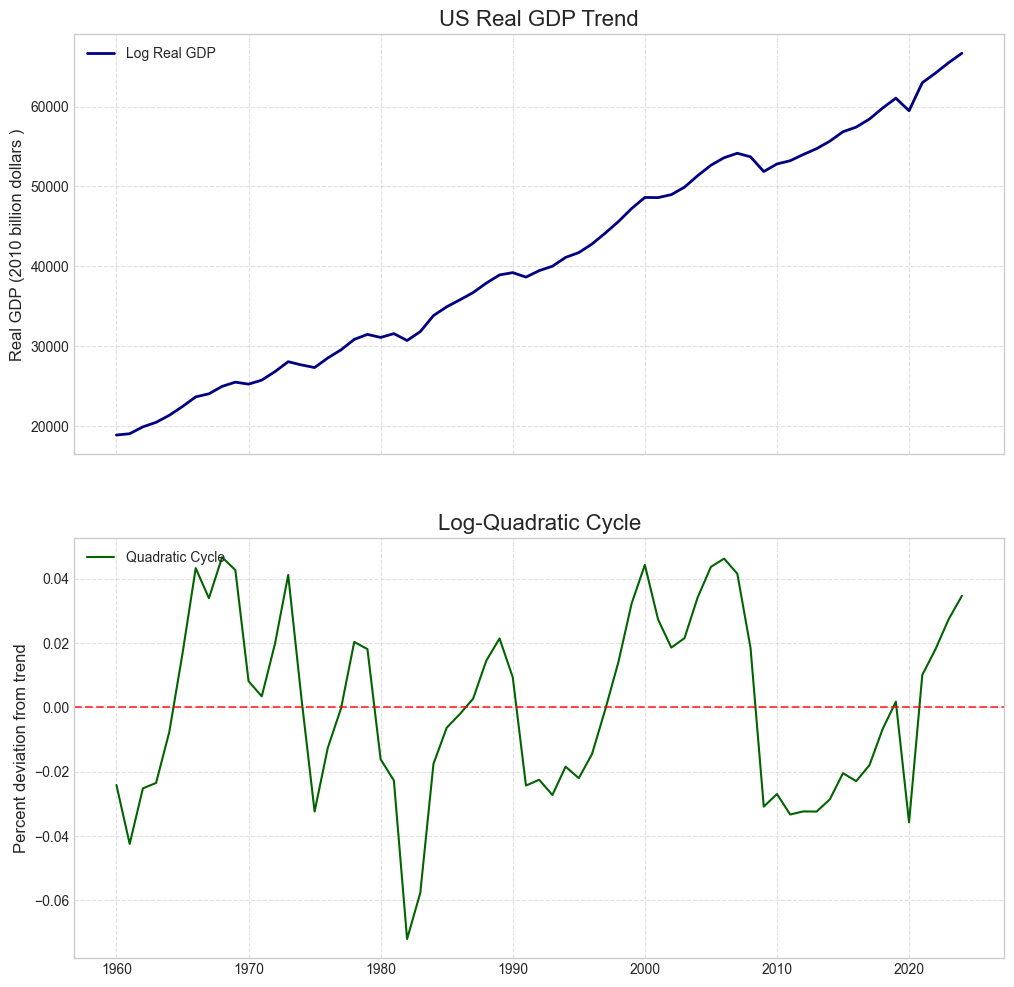

In [44]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.tsatools import detrend

# Import the data
real_gdp = pd.read_excel('rgdp_usa.xlsx',index_col=0)
real_gdp.index = pd.to_datetime(real_gdp.index)

#Keep date from:
keep_date = pd.to_datetime('1947-01-01')
real_gdp = real_gdp[real_gdp.index > pd.to_datetime(keep_date)]
real_gdp.head()

#Log data
log_real_gdp = np.log(real_gdp['GDPC1']).values

#Log-quadtric filter
detrended_quadratic = detrend(log_real_gdp, order=2) 
detrended_quadratic = pd.Series(detrended_quadratic, index=real_gdp.index, name='Cycle (Log-Quadratic)')

print("\nDetrending complete.")

# Plot the filtered GDP series
plt.style.use('seaborn-v0_8-whitegrid')
    
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Top Plot: Original Log GDP (Trend + Cycle)
axes[0].plot(real_gdp.index, real_gdp, label='Log Real GDP', color='navy', linewidth=2)
axes[0].set_title('US Real GDP Trend', fontsize=16)
axes[0].set_ylabel('Real GDP (2010 billion dollars )', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Bottom Plot: Log-Quadratic Cycle (Residuals)
axes[1].plot(detrended_quadratic.index, detrended_quadratic, label='Quadratic Cycle', color='darkgreen', linewidth=1.5)
axes[1].axhline(0, color='red', linestyle='--', alpha=0.7)
axes[1].set_ylabel('Percent deviation from trend', fontsize=12)
axes[1].set_title('Log-Quadratic Cycle', fontsize=16)
axes[1].legend(loc='upper left')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.show()

## Hodrick Prescott (HP) filter

A useful specification is one that allows the growth rate to fluctuate over time.  Hodrick and Prescott (1981) suggest choosing the time-varying trend $\tau_t$ so as to minimize

$$
\min_{\tau_t} f(\tau_t) = \sum_{t=1}^N (y_t-\tau_t)^2+\lambda\sum_{t=2}^{T-2}(\Delta \tau_t-\Delta \tau_{t-1})^2
$$

where the first term is the sum of squared deviations from trend (the cycle component), and the second term is the change in the trend growth rate.  The parameter $\lambda$ puts weight on how smooth we want the trend to be versus the first term which establishes goodness-of-fit.  Notice that as $\lambda \rightarrow 0$ the trend component is just the original time series, and as $\lambda \rightarrow \infty$ the the procedure amounts to a regression on a linear time trend.   The researcher chooses $\lambda$; convention is $\lambda=1600$ for quarterly data, $\lambda=100$ for annual data, and $\lambda=14400$ for monthly data, but this is open to lots of discussion.  The exact solution to this problem is given by

$$
\frac{\partial f}{\partial \tau_t} = 0 \quad \text{for all} \quad  \tau_t
$$

which can be reduced to a linear system of the form

$$
A \cdot \tau = y
$$

where $A$ is an $n \times n$ matric of coefficients determined by the Jacobian, $\tau$ is a $n \times 1$ vector of solutions, and $y$ is the $n \times 1$ vector of time series data.  If you want to see the how to get this formulation look here: https://econ.ubbcluj.ro/ermas2015/lucrari/B1_Adriana_Cornea_Madeira.pdf.  This is a system of $n$ equations in $n$ unknowns so the solution $\tau$ exists.  Although you could solve this problem, there are several packages that perform the HP filter automatically and make small adjustments to improve the performance of the filter. 


Alternatively, you could use the QuantEcon package in Julia:
```julia


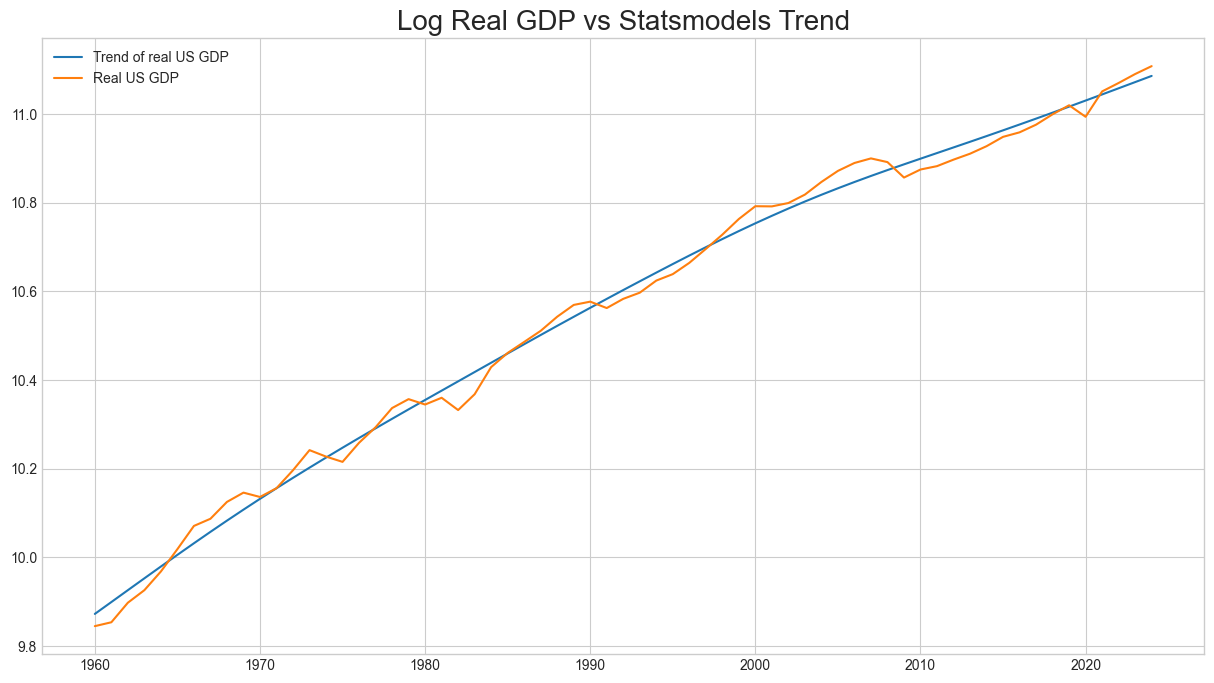

In [45]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Store the cycle and the trend
cycle, trend = sm.tsa.filters.hpfilter(log_real_gdp, 1600)

fig, ax = plt.subplots(1, 1,sharex=True,figsize=(15, 8))

df_trend = pd.DataFrame(index = real_gdp.index, data = trend)
df_log_real_gdp = pd.DataFrame(index = real_gdp.index, data = log_real_gdp)

ax.set_title('Log Real GDP vs Statsmodels Trend',size = 20);

ax.plot(df_trend);
ax.plot(df_log_real_gdp);
ax.legend(['Trend of real US GDP','Real US GDP']);

Alternatively, you could use the QuantEcon package in Julia:
```julia
using QuantEcon
hp_filter(log_real_gdp,1600)
```

## Hamilton filter

Hamilton (2017) identifies several shortcomings of the HP filter:
1. The HP filter produces series with spurious dynamic relations that have no basis in the underlying data-generating process. 
2. Filtered values at the end of the sample are very different from those in the middle, and are also characterized by spurious dynamics. 
3. A statistical formalization of the problem typically produces values for the smoothing parameter vastly at odds with common practice, e.g., a value for λ far below 1600 for quarterly data.

From Hamilton (2017): "Here I suggest an alternative concept of what we might mean by the cyclical component of a possibly nonstationary series: how different is the value at date t + h from the value that we would have expected to see based on its behavior through date t? This concept of the cyclical component has several attractive features."

Hamilton shows that performing an OLS regression of the form:
$$
y_{y+h}=\alpha+\beta_1 y_t+\beta_2 y_{t-1}+\beta_3 y_{t-2}+\beta_4 y_{t-3}+\epsilon_{t+h}
$$
"offer a reasonable way to construct the transient component for a broad class of underlying processes."  

From Hamilton (2017): "A related issue is the choice of h. ...a bigger sample size T will be needed the bigger is h. The information in a finite data set about very long-horizon forecasts is quite limited. If we are interested in business cycles, a 2-year horizon should be the standard benchmark. It is also desirable with seasonal data to have both p and h be integer multiples of the number of observations in a year. Hence for quarterly data my recommendation is p = 4 and h = 8"

https://www.nber.org/papers/w23429
https://notes.quantecon.org/submission/5ba3de34c4ffbc000f71e7aa

QuantEcon provides python packages to easily run a Hamilton filter on data: https://notes.quantecon.org/submission/5ba3de34c4ffbc000f71e7aa

```julia
using QuantEcon
hamilton_filter(data,8,4)
```